In [1]:
#general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob
from astropy.time import Time
import copy
import scipy

#nmma modules
nmmapath = os.getenv('NMMA') # path to nmma from environment variable
sys.path.append(nmmapath) 
import nmma
import nmma.em.utils as utils
import nmma.em.io as io
from nmma.em.model import SimpleKilonovaLightCurveModel,GRBLightCurveModel, SVDLightCurveModel, KilonovaGRBLightCurveModel, GenericCombineLightCurveModel
from nmma.em import training, utils, model_parameters
from nmma.em import analysis

No version information file '.version' found


Install wrapt_timeout_decorator if you want timeout simulations.


In [2]:
import afterglowpy as grb

# Generate a light-curve Bulla 2019 model

In [3]:
model_name = "Bu2019lm"
n_coeff = 3
# The array of times we'll use to examine each lightcurve
tini, tmax, dt = 0.1, 5.0, 0.2
tt = np.arange(tini, tmax + dt, dt)  

# filters to be used
filts = ["u","g","r","i","z","y","J","H","K"] 

In [4]:
# paths
print(os.getcwd())
dataDir = f"{nmmapath}/nmma/tests/data/bulla" # Example absolute path: "/Users/fabioragosta/nmma/nmma/tests/data/bulla"
ModelPath = f"{nmmapath}/nmma/svdmodels/Bu2019lm_tf" # Example absolute path: "/Users/fabioragosta/nmma/svdmodels"
filenames = glob.glob("%s/*.dat" % dataDir)

/home/nvanbemmel/KNTraP/model_fitting/KNTraP-AT2017gfo


In [5]:
# load data
data = io.read_photometry_files(filenames, filters=filts) 
# Load the model data
training_data, parameters = model_parameters.Bu2019lm_sparse(data)

In [6]:
# two different interpolation types are possible "sklearn_gp" or "tensorflow"
interpolation_type = "sklearn_gp"
training_model=training.SVDTrainingModel(
    model_name,
    copy.deepcopy(training_data),
    parameters,
    tt,
    filts,
    svd_path=ModelPath,
    n_coeff=n_coeff,
    interpolation_type=interpolation_type,
    n_epochs=100
)

The grid will be interpolated to sample_time with interp1d
Model exists... will load that model.


In [7]:
tmin, tmax, dt = 0.5, 20.0, 0.1
sample_times = np.arange(tmin, tmax + dt, dt)

light_curve_model = SVDLightCurveModel(
        model_name,
        sample_times,
        svd_path=ModelPath,
        interpolation_type=interpolation_type,
        model_parameters=training_model.model_parameters,
        local_only=True
    )

Loaded filter u
Loaded filter g
Loaded filter r
Loaded filter i
Loaded filter z
Loaded filter y
Loaded filter J
Loaded filter H
Loaded filter K


# 2. Plot AT17gfo light-curve

In [8]:
# import AT2017gfo data
data = pd.read_csv(f'{nmmapath}/example_files/lightcurves/AT2017gfo.dat',header=None,delim_whitespace=True)
data.columns = ['time','filter','mag','magerr']

In [9]:
# convert ISOT time formats into MJD for plotting
times = data['time'].values.tolist()
t = Time(times,format='isot')
data['MJD'] = t.mjd

In [10]:
# colors
data['filter'].unique()
colors = {'sdssu':'purple','ps1::g':'blue','ps1::r':'forestgreen','ps1::i':'gold','ps1::z':'orange','ps1::y':'red','2massj':'lightcoral','2massh':'firebrick','2massks':'darkred'}

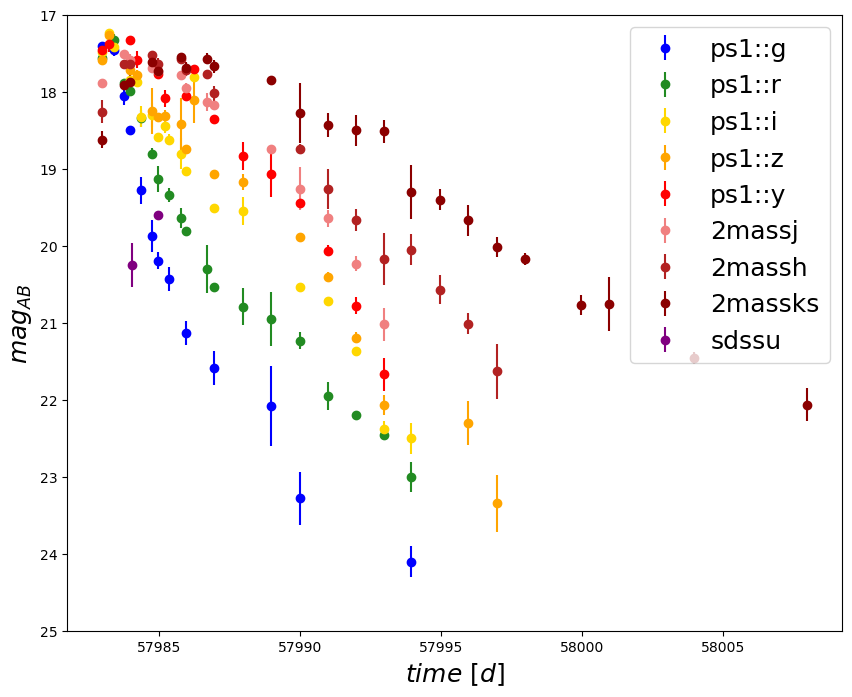

In [11]:
# plot light curve
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(10,8))
for flt in data['filter'].unique():
    sel_flt = data[data['filter'] == flt]
    ax.errorbar(sel_flt['MJD'],sel_flt['mag'],yerr=sel_flt['magerr'],label=flt, color=colors[flt],fmt='o')
ax.set_ylabel(r'$mag_{AB}$', fontsize=18)
ax.set_xlabel(r'$time~[d]$', fontsize=18)
ax.set_ylim([25,17])
ax.legend(fontsize=18)
plt.show()

# 3. Fit Bulla 2019 model to AT17gfo

In [12]:
# not sure how to do model fitting in a jupyter notebook. 
# have only been able to do this using the command line:
# light_curve_analysis --model Bu2019lm --svd-path nmma/svdmodels/ --interpolation_type tensorflow --outdir outdir_at2017gfo_d --label injection --prior nmma/priors/Bu2019lm.at2017gfo.prior --tmin 0.1 --tmax 20 --dt 0.5 --error-budget 1 --nlive 1024 --Ebv-max 0 --trigger-time 57982.5285236896 --data nmma/example_files/lightcurves/GW170817.dat --plot

In [13]:
nmmapath

'/home/nvanbemmel/KNTraP/model_fitting/nmma'

In [20]:
from argparse import Namespace

injectionDir = f'{nmmapath}/nmma/tests/data'

args = Namespace(
    model="Bu2019lm",
    interpolation_type="sklearn_gp",
    svd_path=f'{nmmapath}/nmma/svdmodels/Bu2019lm_tf',
    outdir="./outdir",
    label="injection",
    trigger_time=57982,
    data=f'{nmma}/nmma/example_files/lightcurves/AT2017gfo.dat',
    prior=f'{nmma}/priors/Bu2019lm.prior',
    tmin=0.1,
    tmax=20.0,
    dt=0.5,
    log_space_time=False,
    photometric_error_budget=0.1,
    soft_init=False,
    bestfit=True,
    svd_mag_ncoeff=10,
    svd_lbol_ncoeff=10,
    filters="sdssu",
    Ebv_max=0.0,
    grb_resolution=5,
    jet_type=0,
    error_budget="1",
    sampler="pymultinest",
    cpus=1,
    nlive=1024,
    reactive_sampling=False,
    seed=42,
    injection=f"{injectionDir}/injection.json",
    injection_num=0,
    injection_detection_limit=None,
    injection_outfile="outdir/lc.csv",
    injection_model=None,
    remove_nondetections=True,
    detection_limit=None,
    with_grb_injection=False,
    prompt_collapse=False,
    ztf_sampling=False,
    ztf_uncertainties=False,
    ztf_ToO=None,
    train_stats=False,
    rubin_ToO=False,
    rubin_ToO_type=None,
    xlim="0,14",
    ylim="22,16",
    generation_seed=42,
    plot=True,
    bilby_zero_likelihood_mode=False,
    photometry_augmentation=False,
    photometry_augmentation_seed=0,
    photometry_augmentation_N_points=10,
    photometry_augmentation_filters=None,
    photometry_augmentation_times=None,
    conditional_gaussian_prior_thetaObs=False,
    conditional_gaussian_prior_N_sigma=1,
    sample_over_Hubble=False,
    sampler_kwargs="{}",
    verbose=False,
    local_only=True
    )

analysis.main(args)


Creating light curve model for inference
Creating injection light curve model
Could not find model file for filter sdssu


KeyError: '_mej_dyn'

# 4. Using Bulla obtained parameters generate AT17gfo-like light-curves at different redshifts and samples